In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../dataset/housing.csv')

In [3]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
import matplotlib.pyplot as plt

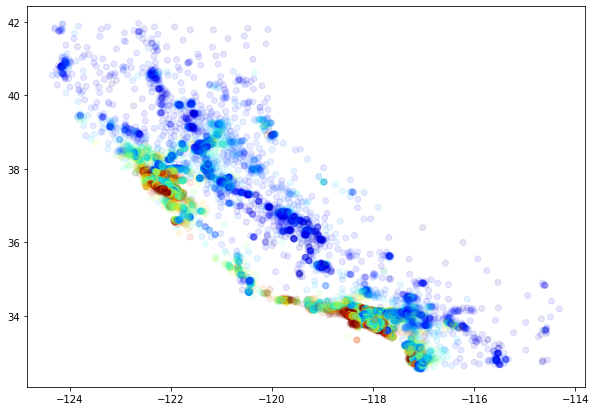

In [5]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.scatter(df['longitude'], df['latitude'],
            c=df['median_house_value'], cmap=plt.get_cmap('jet'),
            marker='o', alpha=0.1)

## Split Dataset

In [56]:
# Split X and y

X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Split the dataset

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=49)

## Check for data types and missing values. Then create corresponding imputers.

In [7]:
# Categorical, numerical?

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 12537 to 426
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18576 non-null  float64
 1   latitude            18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         18576 non-null  float64
 4   total_bedrooms      18387 non-null  float64
 5   population          18576 non-null  float64
 6   households          18576 non-null  float64
 7   median_income       18576 non-null  float64
 8   ocean_proximity     18576 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


Only ocean_proximity is categorical. Check cardinality

In [8]:
# cardinality?

X_train['ocean_proximity'].value_counts()

<1H OCEAN     8217
INLAND        5897
NEAR OCEAN    2379
NEAR BAY      2079
ISLAND           4
Name: ocean_proximity, dtype: int64

Five subcategories -> low cardinality. 

ISLAND subcategory is a peculiarity -> need to check if it has exceptionally high price

In [9]:
# is there null?

X_train.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        189
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [10]:
X_train['total_bedrooms']

12537     278.0
20549     691.0
7810      175.0
18353     181.0
13673    1063.0
          ...  
8050      582.0
7924      600.0
19638       NaN
15861     691.0
426       391.0
Name: total_bedrooms, Length: 18576, dtype: float64

'total_bedrooms' column is likely to have unrecorded data

-> calculate the mean bedroom/room ratio and use the ratio to fill missing values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [53]:
# Create custom imputer 

from sklearn.base import BaseEstimator, TransformerMixin

class TotalBedroomsImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        self.bedroomRatio = (X.loc[:,'total_bedrooms']/X.loc[:,'total_rooms']).mean()
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[:,'total_bedrooms'] = X['total_bedrooms'].fillna(X['total_rooms']*self.bedroomRatio)
        return X

In [86]:
# Create a pipeline
# Impute numerical columns with a SimpleImputer, strategy='median'

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipeline = Pipeline([
    ('totalbedrooms', TotalBedroomsImputer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Split into numerical / categorical

numerical_col = X_train.drop(['ocean_proximity'], axis=1).columns
categorical_col = ['ocean_proximity']

# Merge pipelines

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
])

In [156]:
X_train_transformed = full_pipeline.fit_transform(X_train)

In [122]:
X_train_transformed = pd.DataFrame(X_train_transformed)


In [131]:
X_train_transformed.columns = np.append(numerical_col.values, full_pipeline.transformers_[1][1].get_feature_names(['ocean_proximity']))

In [132]:
X_train_transformed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-0.968906,1.367972,1.384775,-0.530883,-0.617958,-0.787889,-0.545932,-0.570402,0.0,1.0,0.0,0.0,0.0
1,-1.113667,1.433557,-1.639254,0.422437,0.364972,0.607902,0.466927,-0.066435,0.0,1.0,0.0,0.0,0.0
2,0.733279,-0.810377,0.668558,-0.849891,-0.863096,-0.604070,-0.828591,-0.144037,1.0,0.0,0.0,0.0,0.0
3,-1.273403,0.815187,0.668558,-0.548940,-0.848816,-0.772058,-0.810271,3.604973,0.0,0.0,0.0,1.0,0.0
4,1.157577,-0.744792,-0.843457,1.448911,1.250323,1.175190,1.461467,0.301084,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,0.693345,-0.833800,0.907297,-0.016026,0.105554,-0.124734,0.155479,0.052989,1.0,0.0,0.0,0.0,0.0
18572,0.743262,-0.838484,0.191080,-0.117886,0.148394,0.541059,0.244465,-0.130902,1.0,0.0,0.0,0.0,0.0
18573,-0.699352,0.843295,-0.127239,-0.579498,-0.580003,-0.542504,-0.621831,-0.886169,0.0,1.0,0.0,0.0,0.0
18574,-1.408180,0.997887,1.862254,0.351134,0.364972,0.191891,0.252316,-0.088818,0.0,0.0,0.0,1.0,0.0


## Grid Search

In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bootstrap': [True, False], 'n_estimators': [3, 10, 30, 100], 'max_features': [2, 4, 6, 8]}
]

forest_reg = RandomForestRegressor()
gridsearch = GridSearchCV(forest_reg, param_grid, cv=5,
                         scoring='neg_mean_squared_error',
                         return_train_score=True)

gridsearch.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [139]:
gridsearch.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 100}

In [149]:
result = gridsearch.cv_results_
resultlist = list(zip(np.sqrt(-result['mean_test_score']), result['params']))

In [151]:
sorted(resultlist, key = lambda resultlist : resultlist[0])[:5]

[(48331.25677847213,
  {'bootstrap': False, 'max_features': 6, 'n_estimators': 100}),
 (48589.146124803214,
  {'bootstrap': True, 'max_features': 6, 'n_estimators': 100}),
 (48663.80189657778,
  {'bootstrap': True, 'max_features': 8, 'n_estimators': 100}),
 (48716.929672374165,
  {'bootstrap': False, 'max_features': 4, 'n_estimators': 100}),
 (48794.38935227212,
  {'bootstrap': False, 'max_features': 8, 'n_estimators': 100})]

In [152]:
best_model = RandomForestRegressor(n_estimators=100, max_features=6, bootstrap=False)

In [154]:
best_model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=False, max_features=6)

## Test model

In [159]:
X_valid_transformed = full_pipeline.transform(X_valid)

preds = best_model.predict(X_valid_transformed)

In [162]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(preds, y_valid)

In [164]:
np.sqrt(lin_mse)

47349.95794512262

# Exercises

In [181]:
num_pipeline = Pipeline([
    ('totalbedrooms', TotalBedroomsImputer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Split into numerical / categorical

numerical_col = X_train.drop(['ocean_proximity'], axis=1).columns
categorical_col = ['ocean_proximity']

# Merge pipelines

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
])

In [184]:
X_train_transform = full_pipeline.fit_transform(X_train)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_grid = [{
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }]

svr = SVR()
random_search = RandomizedSearchCV(svr, param_grid, cv=5, n_iter=5,
                         scoring='neg_mean_squared_error',
                         return_train_score=True)
random_search.fit(X_train_transform, y_train)

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=5,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fca7c730bb0>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fca7c719b20>,
                                         'kernel': ['linear', 'rbf']}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [195]:
random_search.best_estimator_

SVR(C=121194.32812708982, gamma=0.5871105046974214, kernel='linear')

In [206]:
from sklearn.svm import SVR

feature_importances = random_search.best_estimator_.coef_
features = pd.Series(abs(feature_importances[0]), index=np.append(numerical_col.values, full_pipeline.transformers_[1][1].get_feature_names(['ocean_proximity'])))
X_train_transform = pd.DataFrame(X_train_transform, columns=np.append(numerical_col.values, full_pipeline.transformers_[1][1].get_feature_names(['ocean_proximity'])))
X_train_transform = X_train_transform.loc[:,list(features.nlargest(10).index)]

SVR_best = SVR(C=121194.32812708982, gamma=0.5871105046974214, kernel='linear')
SVR_best.fit(X_train_transform, y_train)

SVR(C=121194.32812708982, gamma=0.5871105046974214, kernel='linear')

In [207]:
X_valid_transform = pd.DataFrame(full_pipeline.transform(X_valid))
X_valid_transform.columns = np.append(numerical_col.values, full_pipeline.transformers_[1][1].get_feature_names(['ocean_proximity']))
X_valid_transform =  X_valid_transform.loc[:,list(features.nlargest(10).index)]
preds = SVR_best.predict(X_valid_transform)

In [208]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(preds, y_valid))

69861.37087614398